Example system as outlined by the pykx guides.
https://code.kx.com/pykx/4.0/examples/streaming/index.html
https://github.com/KxSystems/pykx/blob/main/docs/examples/streaming/Evolving%20System.ipynb

In [1]:
import pykx as kx
import subprocess


Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com



In [ ]:
# Create historical Database
with kx.PyKXReimport():
  db = subprocess.Popen(
    ['python3.13', 'generate_hdb.py',
     '--datapoints', '100000',
     '--days', '5',
     '--name', 'db'],
     stdin=subprocess.PIPE,
     stdout=None,
     stderr=None,
  )

rc = db.wait()
if rc != 0:
  db.stdin.close()
  db.kill()
  raise Exception('Generating HDB failed')
else:
  db.stdin.close()
  db.kill()


Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

Writing Database Partition 2025.12.17 to table trade
Writing Database Partition 2025.12.17 to table quote
Writing Database Partition 2025.12.18 to table trade
Writing Database Partition 2025.12.18 to table quote
Writing Database Partition 2025.12.19 to table trade
Writing Database Partition 2025.12.19 to table quote
Writing Database Partition 2025.12.20 to table trade
Writing Database Partition 2025.12.20 to table quote
Writing Database Partition 2025.12.21 to table trade
Writing Database Partition 2025.12.21 to table quote


In [2]:
# Create the 'BASIC' workflow (which contains ticker, rdb and hdb services)

# Define the hdb schemas (trade/quote) used here as well as the aggregate table used by the rdb
trade = kx.schema.builder({
  'time': kx.TimespanAtom,
  'sym': kx.SymbolAtom,
  'exchange': kx.SymbolAtom,
  'sz': kx.LongAtom,
  'px': kx.FloatAtom
})

quote = kx.schema.builder({
  'time': kx.TimespanAtom,
  'sym': kx.SymbolAtom,
  'exchange': kx.SymbolAtom,
  'bid': kx.FloatAtom,
  'ask': kx.FloatAtom,
  'bidsz': kx.LongAtom,
  'asksz': kx.LongAtom
})

aggregate = kx.schema.builder({
  'time': kx.TimespanAtom,
  'sym': kx.SymbolAtom,
  'trdvol': kx.FloatAtom,
  'maxpx': kx.FloatAtom,
  'minpx': kx.FloatAtom,
  'maxbpx': kx.FloatAtom,
  'minapx': kx.FloatAtom,
  'baspread': kx.FloatAtom
})

basic = kx.tick.BASIC(
  tables={'trade': trade, 'quote': quote, 'aggregate': aggregate},
  ports={'tickerplant': 5010, 'rdb': 5012, 'hdb': 5011},
  log_directory='log',
  database='db'
)
basic.start()

Initialising Tickerplant process on port: 5010

Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

Tickerplant initialised successfully on port: 5010

Starting Tickerplant data processing on port: 5010
Tickerplant process successfully started on port: 5010

Initialising HDB process on port: 5011

Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

HDB initialised successfully on port: 5011

Starting HDB process to allow historical query
Successfully loaded database: db
HDB process successfully started

Initialising Real-time processor on port: 5012

Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials 

In [3]:
#Run a feed process to which we can connect (depends on tickerplant)
with kx.PyKXReimport():
  feed = subprocess.Popen(
    ['python3.13', 'feed.py'],
    stdin=subprocess.PIPE,
    stdout=None,
    stderr=None,
  )

#Run a subscriber (depends on tickerplant)
with kx.PyKXReimport():
  subscriber = subprocess.Popen(
    ['python3.13', 'subscriber.py'],
    stdin=subprocess.PIPE,
    stdout=None,
    stderr=None,
  )


Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

Starting Feedhandler ...
Publishing 1 datpoint(s) every 1 second(s)
First message(s) sent, data-feed publishing ...

Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com



In [12]:
subscriber.stdin.close()
subscriber.kill()

In [ ]:
# Add a chained ticker plant is used for connecting services which perform realtime analytics
# https://code.kx.com/pykx/3.1/user-guide/advanced/streaming/rta.html
chained_tp = kx.tick.TICK(port=5013, chained=True)
chained_tp.start({'tickerplant': 'localhost:5010'})

Initialising Tickerplant process on port: 5013
Trade count: 7
Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

Tickerplant initialised successfully on port: 5013

Starting Tickerplant data processing on port: 5013
Tickerplant process successfully started on port: 5013



In [ ]:
# Create some functions for our real time processor to perform against the chained tickerplant

def pre_processor(table, message):
    if table in ['trade', 'quote']:
        return message
    return None

# Define a Python post-processing function which publishes back to the tickerplant
def post_processor(table, message):
    tradeagg = kx.q.qsql.select('trade',
                                 columns={'trdvol': 'sum px*sz',
                                          'maxpx': 'max px',
                                          'minpx': 'min px'},
                                 by='sym')
    quoteagg = kx.q.qsql.select('quote',
                                 columns={'maxbpx': 'max bid',
                                          'minapx': 'min ask',
                                          'baspread': 'max[bid]-min[ask]'},
                                 by='sym')
    tab = tradeagg.merge(quoteagg, how='left', q_join=True).reset_index()
    tab['time'] = kx.TimespanAtom('now')
    aggregate = kx.q.xcols(['time', 'sym'], tab)
    kx.q['aggregate'] = aggregate
    with kx.SyncQConnection(port=5010, wait=False, no_ctx=True) as q:
        q('.u.upd', 'aggregate', aggregate._values)
    return None

# Create the 'realtime' processor and bind the defined functions to its pre/post processor callbacks
rtp = kx.tick.RTP(port=5014, subscriptions = ['trade', 'quote'], vanilla=False)
rtp.libraries({'kx': 'pykx'})
rtp.pre_processor(pre_processor)
rtp.post_processor(post_processor)

# Attach it to the chained tickerplant
rtp.start({'tickerplant': 'localhost:5013'})

Initialising Real-time processor on port: 5014
Trade count: 21
Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

Real-time processor initialised successfully on port: 5014

Starting Real-time processing on port: 5014
Real-time processing successfully started on port: 5014



In [6]:
# Real-Time Processor: Query the in-memory table using SQL
def RTE_query(sym):
  return kx.q.sql('select count(sym) from trade where sym=$1', sym)

rtp.register_api('custom_rte', RTE_query)

Registering callable function 'custom_rte' on port 5014
Successfully registered callable function 'custom_rte' on port 5014


In [ ]:
# Historical Database: Query using QSQL the on-disk database limiting the search to N-Days in the past
def HDB_query(sym, n):
  today = kx.DateAtom('today')
  return kx.q.qsql.select('trade', {'sym':'count sym'}, where = [f'date in({today-n};{today})', f'sym like "{sym}"'])

basic.hdb.libraries({'kx': 'pykx'})
basic.hdb.register_api('custom_hdb', HDB_query)

Registering callable function 'custom_hdb' on port 5011
Successfully registered callable function 'custom_hdb' on port 5011


In [8]:
# Add a gateway as an entrypoint for users to query real-time and historical data
def gateway_function(sym, n_days=0):
    rte_data = gateway.call_port('rte', 'custom_rte', sym)
    if n_days>0:
        hdb_data = gateway.call_port('hdb', 'custom_hdb', sym, n_days)
    else:
        hdb_data = kx.Table(data={'sym': [0]})
    return rte_data + hdb_data

def user_validation(username, password):
    if username == 'test_user':
        return True
    return False

gateway = kx.tick.GATEWAY(
    port=5015,
    libraries = {'kx': 'pykx'},
    apis = {'gateway_function': gateway_function},
    connections={'hdb': 'localhost:5011', 'rte': 'localhost:5014'},
    connection_validator = user_validation
)
gateway.start()


Initialising Gateway process on port: 5015
Trade count: 40
Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

Registering callable function 'gateway_function' on port 5015
Successfully registered callable function 'gateway_function' on port 5015
Gateway process initialised successfully on port: 5015

Starting Gateway access on port: 5015
Gateway access successfully started on port: 5015



Now we have created a 'basic' streaming platform with the following components & connections
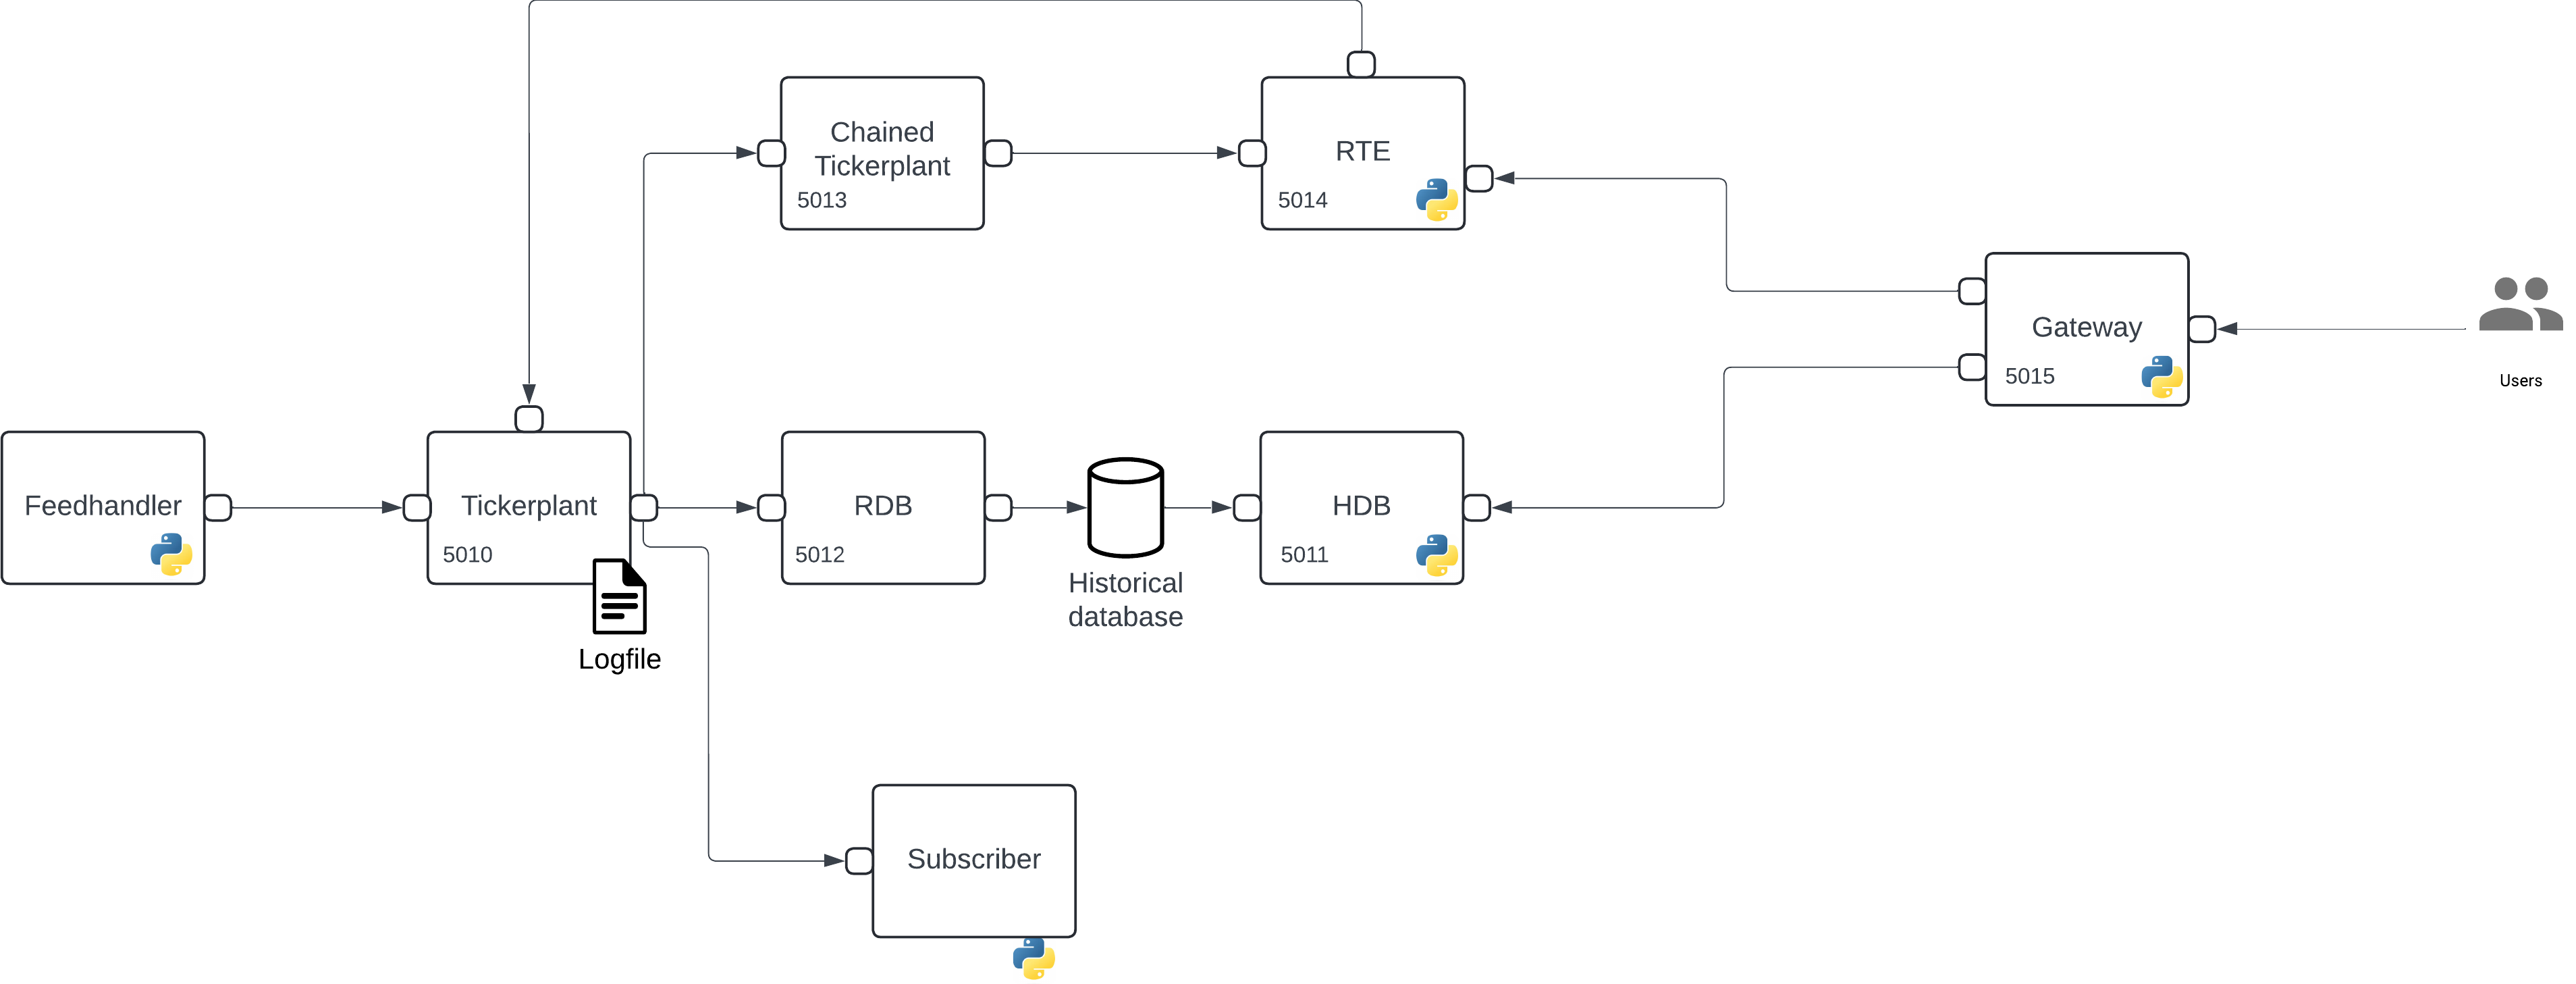

In [9]:
# query the gateway as an end user
with kx.SyncQConnection(port=5015, no_ctx=True, username='test_user') as q:
  data = q('gateway_function', 'AAPL', 0)

data

,sym
,
0,3


In [ ]:
# Now lets connect a dashboard and have it connected off the rtp service
kx.loadExtension

In [10]:
# Stop the feed
feed.stdin.close()
feed.kill()

In [11]:
# Stop the services
rtp.stop()
chained_tp.stop()
basic.stop()
gateway.stop()

Real-time process on port 5014 being stopped
Real-time successfully shutdown on port 5014

Tickerplant process on port 5013 being stopped
Tickerplant successfully shutdown on port 5013

Tickerplant process on port 5010 being stopped


/home/nonroot/.local/lib/python3.13/site-packages/pykx/ipc.py:942: RuntimeWarning: coroutine 'RawQConnection.close' was never awaited
  self.close()
Traceback (most recent call last):
  File "/workspaces/lo.fi/kdb-x/notebooks/subscriber.py", line 44, in <module>
    asyncio.run(main())
    ~~~~~~~~~~~^^^^^^^^
  File "/usr/lib/python3.13/asyncio/runners.py", line 195, in run
    return runner.run(main)
           ~~~~~~~~~~^^^^^^
  File "/usr/lib/python3.13/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/usr/lib/python3.13/asyncio/base_events.py", line 725, in run_until_complete
    return future.result()
           ~~~~~~~~~~~~~^^
  File "/workspaces/lo.fi/kdb-x/notebooks/subscriber.py", line 40, in main
    await main_loop(q, trade, quote)
  File "/workspaces/lo.fi/kdb-x/notebooks/subscriber.py", line 21, in main_loop
    result = q.poll_recv()
  File "/home/nonroot/.local/lib/python3.13/site-

Tickerplant successfully shutdown on port 5010

HDB process on port 5011 being stopped
HDB successfully shutdown on port 5011

Real-time process on port 5012 being stopped
Real-time successfully shutdown on port 5012

Gateway process on port 5015 being stopped
Gateway successfully shutdown on port 5015

